### Amazon Sentiment Analysis

In [111]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from nltk.corpus import stopwords
import re
import os
import en_core_web_sm
nlp = en_core_web_sm.load()

#####  import & rename columns

In [112]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw.columns = ['review','sentiment']

amzn_raw.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


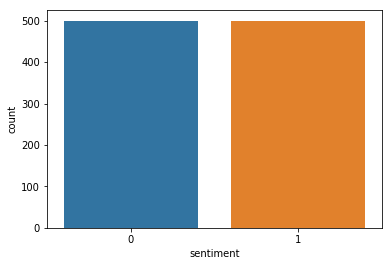

In [174]:
sns.countplot(amzn_raw.sentiment)

##### Clean and process for evaluation

In [113]:
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import bigrams

#stopwords = set(stopwords.words('english'))

STEMMER = SnowballStemmer("english", ignore_stopwords=True)

def preprocess(text: pd.Series) -> pd.Series:
    text = text.apply(gensim.utils.simple_preprocess, min_len=3)
    sw = set(stopwords.words('english')) 
    text = text.apply(lambda s: [w for w in s if w not in sw])
    text = text.apply(lambda s: [STEMMER.stem(w) for w in s])
    #text = text.apply(lambda s: ['_'.join(x) for x in nltk.bigrams(s)] + s)

    return text

##### Create a column of cleaned words

In [71]:
amzn_raw['review'] = preprocess(amzn_raw['review']); amzn_raw.head()

,review,sentiment
0,"[way, plug, unless, convert]",0
1,"[good, case, excel, valu]",1
2,"[great, jawbon]",1
3,"[tie, charger, convers, last, minut, major, pr...",0
4,"[mic, great]",1


##### Run Named Entity Recognition to see what words/categories are in reviews

split into positive and negative reviews

In [84]:
negative = amzn_raw[amzn_raw.sentiment == 0].reset_index()
positive = amzn_raw[amzn_raw.sentiment == 1].reset_index()

##### Get most common word in each review

In [127]:
from collections import Counter

negative_words = negative.review.tolist()
positive_words = positive.review.tolist()

In [123]:
def most_common(words):
    counter = Counter(words[0])
    for i in words[1:]: 
        counter.update(i)

    return counter.most_common()

##### Most common negative

In [125]:
most_common(negative_words)

[('phone', 85),
 ('work', 38),
 ('use', 33),
 ('batteri', 24),
 ('product', 23),
 ('ear', 21),
 ('disappoint', 21),
 ('headset', 20),
 ('one', 19),
 ('time', 19),
 ('money', 18),
 ('poor', 18),
 ('buy', 18),
 ('qualiti', 18),
 ('get', 17),
 ('wast', 17),
 ('would', 17),
 ('first', 17),
 ('call', 17),
 ('sound', 16),
 ('problem', 15),
 ('make', 15),
 ('charg', 15),
 ('servic', 15),
 ('charger', 14),
 ('like', 14),
 ('bad', 14),
 ('worst', 14),
 ('look', 14),
 ('could', 13),
 ('good', 13),
 ('ever', 13),
 ('plug', 12),
 ('last', 12),
 ('drop', 12),
 ('case', 12),
 ('hear', 11),
 ('item', 11),
 ('thing', 11),
 ('realli', 11),
 ('also', 11),
 ('piec', 11),
 ('enough', 10),
 ('still', 10),
 ('terribl', 10),
 ('design', 9),
 ('bought', 9),
 ('return', 9),
 ('unit', 9),
 ('volum', 8),
 ('two', 8),
 ('talk', 8),
 ('turn', 8),
 ('button', 8),
 ('week', 8),
 ('purchas', 8),
 ('broke', 8),
 ('new', 8),
 ('horribl', 8),
 ('custom', 8),
 ('junk', 8),
 ('howev', 8),
 ('tri', 8),
 ('right', 7),
 ('ca

##### Most common positive

In [128]:
most_common(positive_words)

[('great', 94),
 ('phone', 93),
 ('work', 74),
 ('good', 65),
 ('use', 38),
 ('well', 35),
 ('headset', 35),
 ('product', 33),
 ('sound', 31),
 ('qualiti', 31),
 ('price', 30),
 ('excel', 28),
 ('batteri', 24),
 ('case', 23),
 ('one', 23),
 ('love', 23),
 ('nice', 23),
 ('comfort', 22),
 ('recommend', 21),
 ('best', 21),
 ('ear', 20),
 ('like', 19),
 ('would', 17),
 ('fit', 16),
 ('realli', 15),
 ('get', 15),
 ('easi', 15),
 ('bluetooth', 14),
 ('happi', 13),
 ('purchas', 13),
 ('time', 13),
 ('new', 12),
 ('fine', 12),
 ('better', 12),
 ('high', 11),
 ('car', 11),
 ('even', 11),
 ('look', 11),
 ('year', 11),
 ('devic', 11),
 ('also', 11),
 ('recept', 11),
 ('far', 10),
 ('make', 10),
 ('camera', 10),
 ('clear', 10),
 ('problem', 10),
 ('cell', 10),
 ('item', 9),
 ('tri', 9),
 ('got', 9),
 ('bought', 8),
 ('charg', 8),
 ('charger', 8),
 ('made', 8),
 ('pretti', 8),
 ('wear', 8),
 ('lot', 8),
 ('motorola', 8),
 ('jabra', 8),
 ('servic', 8),
 ('life', 8),
 ('long', 8),
 ('without', 7),
 

#### Identify Keywords

Reset original reviews

In [143]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw.columns = ['review','sentiment']

amzn_raw.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [144]:
keywords = ['great',     #good
            'Excellent', 
            'battery',   #bad
            'junk',
            'disappointed',
            'plug'
    ]

for key in keywords:
    data[str(key)] = amzn_raw.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

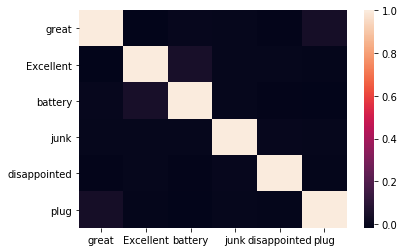

In [145]:
sns.heatmap(data.corr())

##### Fit the data

In [146]:
data = data[keywords]
target = amzn_raw['sentiment']

In [149]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 462


##### Calculate the confusion matrix

In [150]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[484,  16],
       [446,  54]])

In [151]:
1-(target != y_pred).sum()/len(target)

0.538

So on the first pass we got an accuracy of 53%

### Run #2

In [190]:
keywords = ['great',     #good
            'Excellent',
            'love',
            'comfort',
            'happy'
            'battery',   #bad
            'junk',
            'disappointed',
            'plug',
            'flaw',
            'cheap'
    ]

for key in keywords:
    data[str(key)] = amzn_raw.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [191]:
data = data[keywords]
target = amzn_raw['sentiment']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print(1-(target != y_pred).sum()/len(target))

Number of mislabeled points out of a total 1000 points : 444
0.556


In [167]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[499,   1],
       [443,  57]])

Type I errors/false positive/id'd as negative but was not: 1
Type II/false negative/id'd as positive when it was not: 443. 

We have more cases where the review was identified as positive when it was negative

### Run #3

In [206]:
keywords = ['great',     #good
            'Excellent',
            'love',
            'comfort',
            'battery',   #bad
            'junk',
            'disappointed',
    ]

for key in keywords:
    data[str(key)] = amzn_raw.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [207]:
data = data[keywords]
target = amzn_raw['sentiment']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print(1-(target != y_pred).sum()/len(target))
print(confusion_matrix(target, y_pred))

Number of mislabeled points out of a total 1000 points : 444
0.556
[[499   1]
 [443  57]]


##### Cross validation

In [208]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.53
Testing on Sample: 0.556
